In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.decomposition import PCA

In [2]:
import matplotlib.pyplot as plt
import matplotlib
zhfont1 = matplotlib.font_manager.FontProperties(fname='C:\Windows\Fonts\simkai.ttf')

In [615]:
import datetime
from dateutil.relativedelta import relativedelta

## 读取数据

In [3]:
df = pd.read_excel('社融&国房指数.xls',index_col = 0)
df.index = pd.to_datetime(df.index)

In [4]:
df.head()

,社会融资规模:当月值,国房景气指数
2002-01-31,-472.0,103.91
2002-02-28,289.0,103.53
2002-03-31,3136.0,103.87
2002-04-30,1151.0,104.37
2002-05-31,1774.0,104.60


In [5]:
dollar = pd.read_excel('美元指数.xls',index_col = 0)
term = pd.read_excel('国债期限利差.xls',index_col = 0)
interest = pd.read_excel('1年期国债收益率.xls',index_col = 0)

In [6]:
dollar.tail()

,美元指数
2019-04-24,98.0905
2019-04-25,98.1789
2019-04-26,98.0330
2019-04-29,97.8394
2019-04-30,97.5235


In [7]:
interest = - interest
term = term
interest.tail()


,中债国债到期收益率:1年
2019-04-25,-2.6902
2019-04-26,-2.6742
2019-04-28,-2.6988
2019-04-29,-2.7223
2019-04-30,-2.6902


In [8]:
#日度时间序列
oldtimes = df.index[:-1]

In [9]:
# 月度时间序列
newtimes = []
for thetime in oldtimes:
    if thetime.month != 1:
        newtimes.append(thetime)

## 所有指标处理成月度数据

In [10]:
def last3month(time):
    if time.month<3:
        result = str(time.year-1) + '-' + str(12+time.month-2)
    else:
        if time.month < 12:
            result = str(time.year) + '-0' + str(time.month-2)
        else:
            result = str(time.year) + '-10'
            
    return result


alldata = pd.DataFrame(index = newtimes, columns = ['社融规模mean','社融规模sum','社融规模last','国房景气指数','美元指数','国债收益率','利差'])
for thetime in newtimes:
    alldata['国房景气指数'][thetime] = df['国房景气指数'][thetime]
    if thetime.month !=2:
        themonth = str(thetime)[:7]
        alldata['社融规模mean'][thetime] = df['社会融资规模:当月值'][thetime]        
        alldata['社融规模sum'][thetime] = df['社会融资规模:当月值'][thetime] 
        alldata['社融规模last'][thetime] = df['社会融资规模:当月值'][thetime]
        alldata['美元指数'][thetime] = dollar[themonth].mean().values[0]
        alldata['国债收益率'][thetime] = interest[themonth].mean().values[0]
        l3m = last3month(thetime)
        alldata['利差'][thetime] = term[l3m:themonth].mean().values[0]
    else:
        themonth = str(thetime)[:7]
        lastmonth = str(thetime.year) + '-01'
        alldata['社融规模mean'][thetime] = df['社会融资规模:当月值'][lastmonth:themonth].mean()
        alldata['社融规模sum'][thetime] = df['社会融资规模:当月值'][lastmonth:themonth].sum()
        alldata['社融规模last'][thetime] = df['社会融资规模:当月值'][lastmonth].values[0]
        alldata['美元指数'][thetime] = dollar[lastmonth:themonth].mean().values[0]
        alldata['国债收益率'][thetime] = interest[lastmonth:themonth].mean().values[0]
        l3m = last3month(thetime)
        alldata['利差'][thetime] = term[l3m:themonth].mean().values[0]

In [11]:
alldata.head()

,社融规模mean,社融规模sum,社融规模last,国房景气指数,美元指数,国债收益率,利差
2002-02-28,-91.5,-183,-472,103.53,118.339,-2.15214,0.578084
2002-03-31,3136,3136,3136,103.87,117.955,-1.9575,0.562828
2002-04-30,1151,1151,1151,104.37,116.884,-1.97943,0.449742
2002-05-31,1774,1774,1774,104.6,113.383,-1.88149,0.390643
2002-06-30,2621,2621,2621,104.65,109.586,-1.79802,0.332803


In [12]:
alldata.isna().sum()

社融规模mean    0
社融规模sum     0
社融规模last    0
国房景气指数      0
美元指数        0
国债收益率       0
利差          0
dtype: int64

In [13]:
#alldata[alldata['国房景气指数'].isna()]

## 1/2月社融数据按照 取平均、取和、取1月值 三种方式处理结果

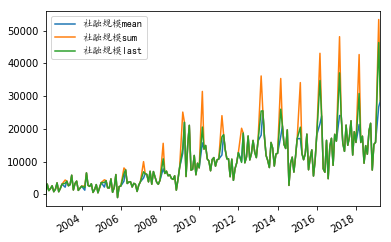

In [14]:
alldata[['社融规模mean','社融规模sum','社融规模last']].plot()
plt.legend(prop=zhfont1)

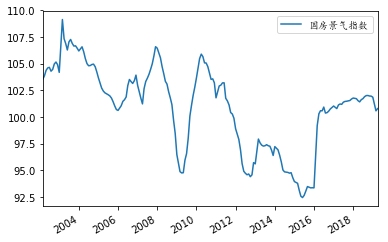

In [15]:
alldata[['国房景气指数']].plot()
plt.legend(prop=zhfont1)

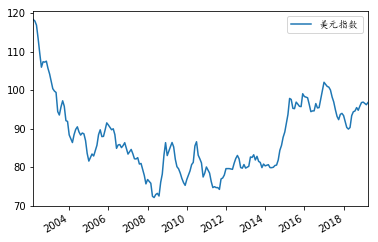

In [16]:
alldata[['美元指数']].plot()
plt.legend(prop=zhfont1)

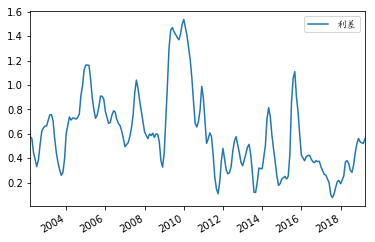

In [17]:
alldata[['利差']].plot()
plt.legend(prop=zhfont1)

## MA与延期处理

In [18]:
alldata['国债收益率shift11'] = alldata['国债收益率'].shift(11)
alldata['社融sum_MA11'] = alldata['社融规模sum'].rolling(11).mean()
alldata['社融mean_MA11'] = alldata['社融规模mean'].rolling(11).mean()
alldata['社融last_MA11'] = alldata['社融规模last'].rolling(11).mean()

In [19]:
alldata = alldata.dropna()

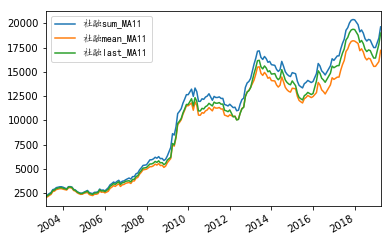

In [20]:
alldata[['社融sum_MA11','社融mean_MA11','社融last_MA11']].plot()
plt.legend(prop=zhfont1)

In [21]:
alldata['新增社融sum'] = alldata['社融sum_MA11']/alldata['社融sum_MA11'].shift(11) - 1
alldata['新增社融mean'] = alldata['社融mean_MA11']/alldata['社融mean_MA11'].shift(11) - 1
alldata['新增社融last'] = alldata['社融last_MA11']/alldata['社融last_MA11'].shift(11) - 1

## 新增社融

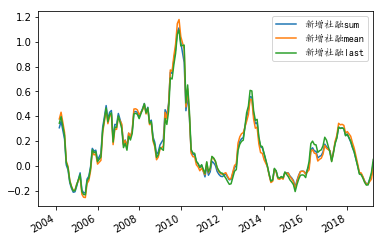

In [22]:
alldata[['新增社融sum','新增社融mean','新增社融last']].plot()
plt.legend(prop=zhfont1)

In [23]:
alldata = alldata.dropna()

In [24]:
alldata.head()

,社融规模mean,社融规模sum,社融规模last,国房景气指数,美元指数,国债收益率,利差,国债收益率shift11,社融sum_MA11,社融mean_MA11,社融last_MA11,新增社融sum,新增社融mean,新增社融last
2004-02-29,1276,2552,2114,106.58,86.3898,-2.39231,0.73818,-1.6556,2934.636364,2818.636364,2894.818182,0.307982,0.378735,0.344608
2004-03-31,6557,6557,6557,106.11,88.4578,-2.48729,0.713326,-1.7344,3163.363636,3047.363636,3123.545455,0.360055,0.432950,0.397446
2004-04-30,2731,2731,2731,105.48,89.7995,-2.66014,0.73022,-1.92496,3173.272727,3057.272727,3133.454545,0.290139,0.352558,0.322742
2004-05-31,2443,2443,2443,105,90.4729,-2.84195,0.730027,-2.04215,3125.272727,3009.272727,3085.454545,0.216791,0.270174,0.245276
2004-06-30,3229,3229,3229,104.8,89.155,-2.95709,0.720703,-2.17655,2887.727273,2771.727273,2847.909091,0.009246,0.041220,0.027924


In [25]:
#newdata = alldata[['新增社融sum','国债收益率shift11','国房景气指数','美元指数']]
#newdata.columns = ['新增社融','国债收益率','国房景气指数','美元指数']
#newdata = alldata[['新增社融sum','利差','国房景气指数','美元指数']]
#newdata.columns = ['新增社融','利差','国房景气指数','美元指数']
newdata = alldata[['新增社融sum','国房景气指数','国债收益率shift11']]
newdata.columns = ['新增社融','国房景气指数','国债收益率shift11']

In [26]:
newdata_standard = newdata/newdata.iloc[0]*100

## 处理完成后的指标

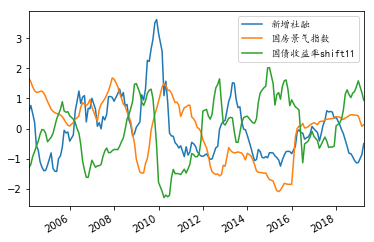

In [27]:
newdata_standard = (newdata_standard-newdata_standard.mean())/newdata_standard.std()

newdata_standard.plot()
plt.legend(prop=zhfont1)


## 定义求取主成分的函数

In [28]:
def get_Primary(newdata):
    thetimes = newdata['2010':].index
    Primary = pd.Series(index = thetimes)#存储主成分结果序列
    Primary.iloc[0] = 100
    weight = pd.DataFrame()#存储指标权重值
    weight2 = pd.DataFrame()#储存权重值翻转处理后结果
    #Primary2 = pd.Series(index = thetimes)
    #Primary2.iloc[0] = 100
    midvalue = 100
    midvalue2 = 100
    loading = pd.DataFrame()#储存因子载荷
    loading2 = pd.DataFrame()#因子载荷反转后结果
        
    for time in thetimes[1:]:
        strtime = str(time)
        yr = int(strtime[:4])
        
        # 若数据不足7年则从2005年开始
        if yr-7 < 2005:
            yr = 2005
        else:
            yr = yr - 7
            
        btime = str(yr)+strtime[4:7]#滚动窗起始时间
        thedata = newdata[btime:time]
        
        thedata_standard = (thedata-thedata.mean())/thedata.std()#原始数据标准化
        X = np.array(thedata_standard)
        pca = PCA(n_components=1)#调包PCA
        newX = pca.fit_transform(X)
        PC = pd.DataFrame(newX)#窗口期内主成分序列结果
        
        spect = pca.components_#特征向量
        contr = pca.explained_variance_ratio_[0]#方差贡献
        theloading = spect*(contr**2)#因子载荷
        loading = pd.concat([loading,pd.DataFrame(theloading)])
        weight = pd.concat([weight,pd.DataFrame(spect)])
                
        PC = PC/theloading.sum()*100
        PC = (PC - PC.mean())/PC.std()+100#进一步标准化
        PC = PC/PC.iloc[0]*100
        
        change = PC.iloc[-1] - PC.iloc[-2]#获得窗口期主成分序列最后两项差值
        midvalue = change + midvalue
        Primary[time] = midvalue

    loading.index = thetimes[1:]
    loading.columns = newdata.columns

    weight.index = thetimes[1:]
    weight.columns = newdata.columns
    return loading,weight,Primary

In [29]:
loading,weight,Primary = get_Primary(newdata)

## 严格按照上述步骤求出的主成分结果

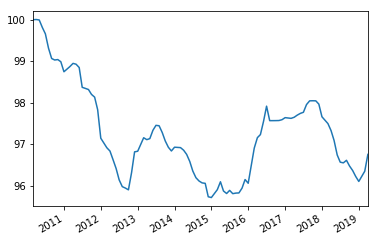

In [30]:
Primary['2010':].plot()

### 因子载荷结果

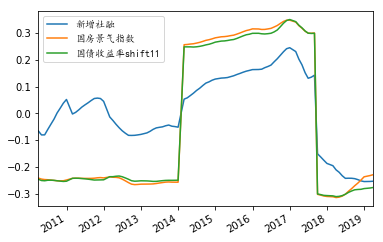

In [31]:
loading.plot()
plt.legend(prop=zhfont1)

### 权重结果

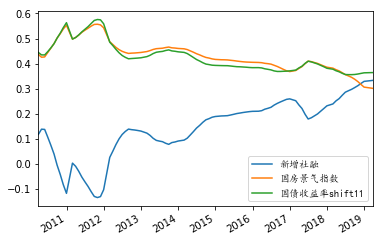

In [32]:
#weight.plot()
#plt.legend(prop=zhfont1)

s = np.sum(weight,axis=1)
(weight.div(s,axis=0)).plot()
plt.legend(prop=zhfont1)


## 所有历史数据一步PCA

In [33]:
thedata = newdata
thedata_standard = (thedata-thedata.mean())/thedata.std()
X = np.array(thedata_standard)
pca = PCA(n_components=1)
newX = pca.fit_transform(X)
spect = pca.components_
contr = pca.explained_variance_ratio_[0]
allloading = spect*(contr**2)

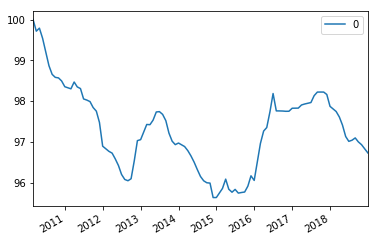

In [34]:
PC = pd.DataFrame(newX)
PC.index = newdata.index
PC = PC['2010':]
PC = PC/allloading.sum()*100
PC = (PC - PC.mean())/PC.std()
PC = PC-PC.iloc[0]+100
allPC = PC[0]
PC['2010':'2018'].plot()

In [35]:
spect## 权重

array([[0.40703812, 0.64310365, 0.64864294]])

## 国债收益率数据读出与初步处理

In [36]:
bondreturn = pd.read_excel('国开债指数.xlsx',index_col = 0)

In [37]:
bondreturn.tail()

,CBA02521,CBA02531,CBA02541,CBA02551
2019-05-16,179.3774,189.4799,199.0154,192.8042
2019-05-17,179.3807,189.5223,199.0362,192.9113
2019-05-20,179.4347,189.5482,199.1648,192.9557
2019-05-21,179.4032,189.3309,198.9315,192.6849
2019-05-22,179.3127,189.1332,198.8610,192.5620


In [38]:
bondindex = PC.index
bondreturnM = pd.DataFrame(index = bondindex, columns = ['净值','收益率'])
bondreturnN = pd.DataFrame(index = bondindex, columns = ['净值','收益率'])
for thetime in bondindex:
    themonth = str(thetime)[:7]
    bondreturnM['净值'][thetime] = bondreturn['CBA02551'][themonth].iloc[-1]
    bondreturnN['净值'][thetime] = bondreturn['CBA02521'][themonth].iloc[-1]
bondreturnM['收益率'] = bondreturnM['净值']/bondreturnM['净值'].shift(1) - 1
bondreturnN['收益率'] = bondreturnN['净值']/bondreturnN['净值'].shift(1) - 1
bondreturnM = bondreturnM.fillna(0)
bondreturnN = bondreturnN.fillna(0)

In [39]:
bondreturnM.head()
bondreturnN.head()

,净值,收益率
2010-02-28,125.6887,0.000000
2010-03-31,126.2461,0.004435
2010-04-30,126.6641,0.003311
2010-05-31,126.8452,0.001430
2010-06-30,126.7201,-0.000986


## 定义构造多空策略的函数

In [40]:
def longshort(signal, monthreturn1,monthreturn2):
    long = (signal<=signal.shift(1))
    short = (signal>signal.shift(1))
    strategy_month1 = long*monthreturn1
    strategy_month2 = short*monthreturn2
    cum1 = (strategy_month1+1).cumprod()
    cum2 = (strategy_month2+1).cumprod()
    
    ls = long.astype('int') - short.astype('int')
    return (cum1*cum2)*100,ls

### 用严格按照步骤窗口处理获得的PCA序列做的多空策略结果

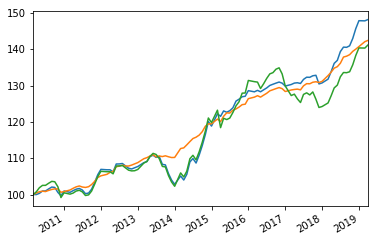

In [41]:
returns,ls = longshort(Primary.shift(1),bondreturnM['收益率'],bondreturnN['收益率'])
returns.plot()
(bondreturnN['净值']/bondreturnN['净值'][0]*100).plot()
(bondreturnM['净值']/bondreturnM['净值'][0]*100).plot()

# 多空信号

(0.0048264844774530665, -0.0034420546021378044, 0.47)

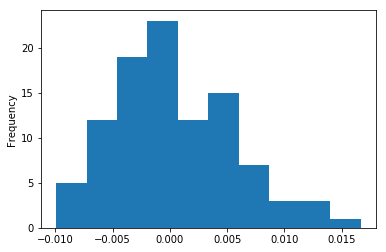

In [42]:
r = returns/returns.shift(1) - 1
rbN = bondreturnN['净值']/bondreturnN['净值'].shift(1) - 1
rbM = bondreturnM['净值']/bondreturnM['净值'].shift(1) - 1

(r-rbM/2-rbN/2).plot(kind = 'hist')

rate = ((r-rbM/2-rbN/2)>0).sum()/(r-rbM).count()

alpha = r-rbM/2-rbN/2

up = alpha[alpha>0].mean()
down = alpha[alpha<0].mean()

up,down,rate

### 用所有历史数据一步PCA序列做的多空策略结果

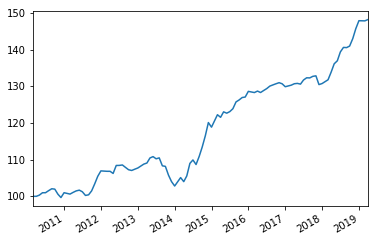

In [43]:
returns.ls = longshort(allPC,bondreturnM['收益率'],bondreturnN['收益率'])
returns.plot()

# 在国开债指数上回测的动量策略

In [44]:
bondreturn = pd.read_excel('国开债指数.xlsx',index_col = 0)

In [45]:
bondreturn.tail()

,CBA02521,CBA02531,CBA02541,CBA02551
2019-05-16,179.3774,189.4799,199.0154,192.8042
2019-05-17,179.3807,189.5223,199.0362,192.9113
2019-05-20,179.4347,189.5482,199.1648,192.9557
2019-05-21,179.4032,189.3309,198.9315,192.6849
2019-05-22,179.3127,189.1332,198.8610,192.5620


In [46]:
idx = bondreturn.index

dates = []
months = []
for dt in idx:
    dates.append(dt)
    months.append(str(dt)[:7])
    
    
pd_dates = pd.DataFrame({'dt':dates, 'mth':months},index=dates)

pd_dates = pd_dates['2004':]

mthend = pd.Series(index=pd_dates.index)

for dt in pd_dates.index:
    m = str(dt)[:7]
    mthend[dt] = pd_dates['dt'][m].max()
    
mthend = mthend.unique()
mthend = pd.Series(mthend,index=mthend)
mthend.head()

2004-01-30   2004-01-30
2004-02-27   2004-02-27
2004-03-31   2004-03-31
2004-04-30   2004-04-30
2004-05-31   2004-05-31
dtype: datetime64[ns]

In [552]:
bondindex = mthend.index
mom6m = pd.DataFrame(index = bondindex, columns = ['净值1','净值2','动量lag1','当月收益1','当月收益2'])
for thetime in bondindex:
    themonth = str(thetime)[:7]
    mom6m['净值1'][thetime] = bondreturn['CBA02551'][themonth].iloc[-1]
    mom6m['净值2'][thetime] = bondreturn['CBA02521'][themonth].iloc[-1]
mom6m['动量lag1'] = (mom6m['净值1']/mom6m['净值1'].shift(1) - mom6m['净值2']/mom6m['净值2'].shift(1)).shift(1)
mom6m['当月1减2'] = mom6m['净值1']/mom6m['净值1'].shift(1) - mom6m['净值2']/mom6m['净值2'].shift(1)
mom6m['当月收益1'] = mom6m['净值1']/mom6m['净值1'].shift(1) - 1
mom6m['当月收益2'] = mom6m['净值2']/mom6m['净值2'].shift(1) - 1
mom6m = mom6m.fillna(0)

mom6m = mom6m['2005':]
mom6m.head()

,净值1,净值2,动量lag1,当月收益1,当月收益2,当月1减2
2005-01-31,107.2848,105.5579,-0.001597,0.009410,0.010886,-0.001476
2005-02-28,107.9080,106.2367,-0.001476,0.005809,0.006431,-0.000622
2005-03-31,109.8612,106.9353,-0.000622,0.018101,0.006576,0.011525
2005-04-29,110.4914,107.8031,0.011525,0.005736,0.008115,-0.002379
2005-05-31,111.1378,108.3119,-0.002379,0.005850,0.004720,0.001131


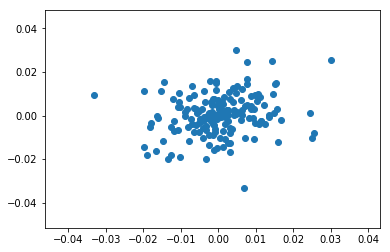

In [553]:
plt.scatter(mom6m['动量lag1'],mom6m['当月1减2'])

In [554]:
X = mom6m['动量lag1'].values.reshape(-1,1)
y = mom6m['当月1减2'].values.reshape(-1,1)

from sklearn.linear_model import LinearRegression
modelm = LinearRegression()
modelm.fit(X,y)

modelm.coef_,modelm.intercept_,modelm.score(X,y)

(array([[0.1960491]]), array([0.00030528]), 0.038427554339259595)

In [623]:
def momentum(signal, monthreturn1,monthreturn2):
    short = (signal<=0)
    long = (signal>0)
    strategy_month1 = long*monthreturn1
    strategy_month2 = short*monthreturn2
    cum1 = (strategy_month1+1).cumprod()
    cum2 = (strategy_month2+1).cumprod()
    
    ls = long.astype('int') - short.astype('int')
    
    this_mth = monthreturn1.index[0]
    prev_mth = this_mth - relativedelta(month=1)
    
    #nav = pd.concat([pd.Series([100],index=[datetime.datetime(2004,12,31)]),(cum1*cum2)*100])
    nav = pd.concat([pd.Series([100],index=[prev_mth]),(cum1*cum2)*100])
    
    ret = strategy_month1.copy()
    ret[short] = strategy_month2[short]
    
    return nav,ls,ret
    

In [624]:
nav,ls,ret = momentum(mom6m['动量lag1'],mom6m['当月收益1'],mom6m['当月收益2'])

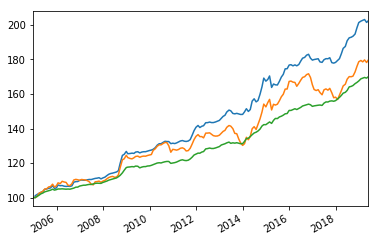

In [646]:
nav.plot()

nav1 = pd.concat([pd.Series([100],index=[datetime.datetime(2004,12,31)]),(mom6m['净值1']/mom6m['净值1'][0]*100)])
nav2 = pd.concat([pd.Series([100],index=[datetime.datetime(2004,12,31)]),(mom6m['净值2']/mom6m['净值2'][0]*100)])

nav1.plot()
nav2.plot()

In [626]:
r = ret

rb10 = mom6m['当月收益1'] # 7~10年债
rb1 = mom6m['当月收益2']

rate = ((r-rb10/2-rb1/2)>0).sum()/r.count()

alpha = r-rb10/2-rb1/2

up = alpha[alpha>0].mean()
down = alpha[alpha<0].mean()

up,down,rate
#alpha.plot(kind='hist')

(0.003480446959657265, -0.003450180304516781, 0.6127167630057804)

# 凸度和期限利差用于择时

In [627]:
curv = pd.read_excel('凸度.xls',index_col = 0)
spd = pd.read_excel('国债期限利差.xls', index_col = 0)

idx = curv.index.drop_duplicates(keep='last')

curv_mth = pd.Series(index = idx)
spd_mth = pd.Series(index = idx)
for i in idx:
    mth = str(i)[:7]
    curv_mth[i] = curv[mth].mean().values[0]
    spd_mth[i] = spd[mth].mean().values[0]

# 前移1个月
curv_mth = curv_mth[mthend]
curv_mth = curv_mth.shift(1) ###一定要用一个月前的！！
curv_mth = curv_mth['2005':]

spd_mth = spd_mth[mthend]
spd_mth = spd_mth.shift(1) ###一定要用一个月前的！！
spd_mth = spd_mth['2005':]

curv_mth.tail()

2019-01-31    0.143663
2019-02-28    0.199568
2019-03-29    0.347703
2019-04-30    0.435186
2019-05-22    0.382570
dtype: float64

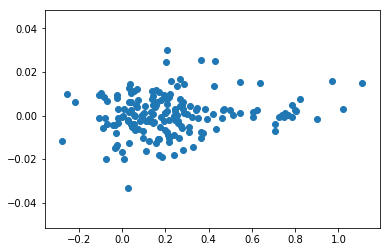

In [628]:
plt.scatter(curv_mth,rb10-rb1) #看起来凸度高短期内对10年券比较有利，说明预期10年要下?

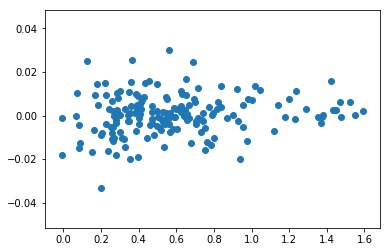

In [629]:
plt.scatter(spd_mth,rb10-rb1) # 好像5-1利差的效果没有凸度好

In [630]:
nav_spd,ls_spd,ret_spd = momentum(spd_mth-0.50,rb10,rb1)

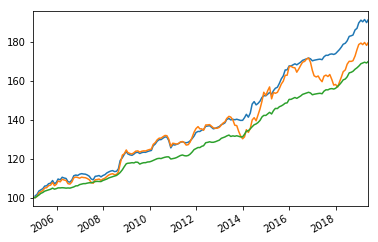

In [631]:
nav_spd.plot()

nav1.plot()
nav2.plot()

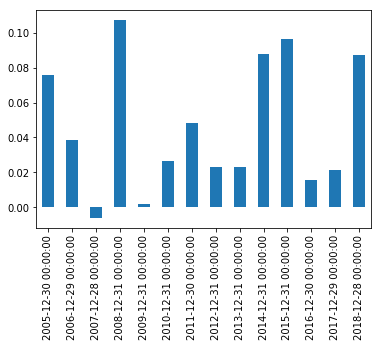

In [644]:
alpha_spd = ret_spd - rb1
alpha_spd_yr = alpha_spd.rolling(12).sum()
ret_spd_yr = ret_spd.rolling(12).sum()
ret_spd_yr.mean()
ret_spd_yr[11::12].plot(kind='bar')

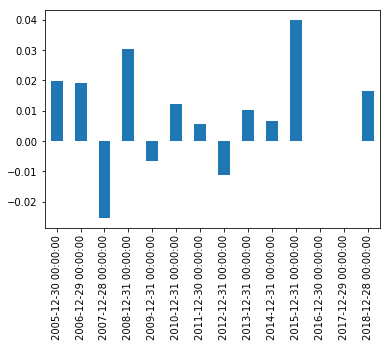

In [645]:
alpha_spd_yr[11::12].plot(kind='bar')

In [632]:
nav_curv,ls_curv,ret_curv = momentum(curv_mth-0.18,rb10,rb1)

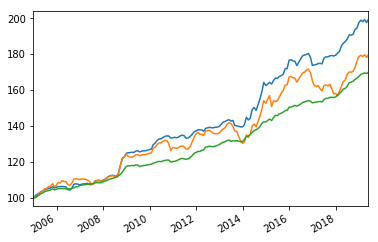

In [633]:
nav_curv.plot()
nav1.plot()
nav2.plot()

In [634]:
same = ls[ls==ls_spd]
diff = ls[ls!=ls_spd]
same.shape, diff.shape

((92,), (81,))

In [635]:
ls_spd = spd_mth > spd_mth.rolling(60).mean()
ls_spd[pd.isnull(spd_mth.rolling(60).mean())] = 0

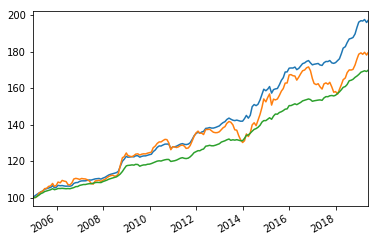

In [636]:
ls_all = ls_spd + (ls+1)/2
ls_all = pd.Series(ls_all/2,index=rb10.index)

ret_all = pd.Series(np.zeros(ls_all.shape[0]),index = rb10.index)
ret_all[ls_all>0] = rb10[ls_all>0] * ls_all[ls_all>0] + rb1[ls_all>0] * (1-ls_all[ls_all>0])
ret_all[ls_all==0] = rb1[ls_all==0]

nav_all = (1+ret_all).cumprod()*100
nav_all = pd.concat([pd.Series([100],index=[datetime.datetime(2004,12,31)]),nav_all])

nav_all.plot()
nav1.plot()
nav2.plot()

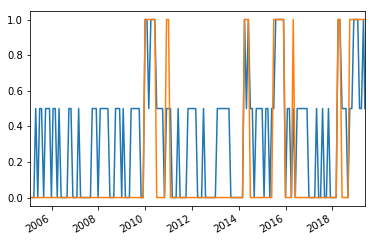

In [637]:
ls_all.plot()
ls_spd.plot()

(0.0008184590263706212, 0.0014159341156211747)

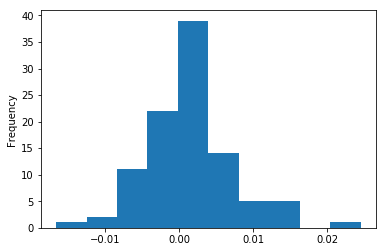

In [638]:
(ret_all-rb1)[ls_all>0].plot(kind='hist')
(ret_all-rb1).mean(), (ret_all-rb1)[ls_all>0].mean() 

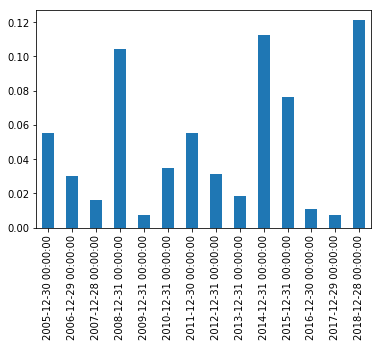

In [640]:
alpha_all = ret_all - rb1
alpha_yr = alpha_all.rolling(12).sum()
ret_yr = ret_all.rolling(12).sum()
ret_yr.mean()
ret_yr[11::12].plot(kind='bar')

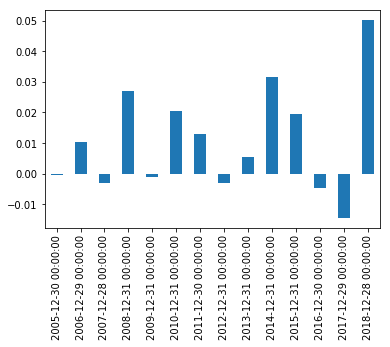

In [641]:
alpha_yr[11::12].plot(kind='bar')

# 从凸性里面剥离期限利差

In [196]:
from sklearn.linear_model import LinearRegression

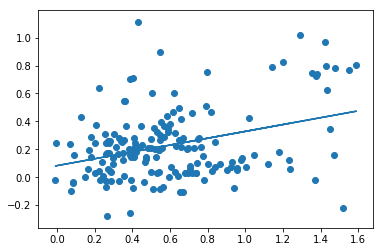

In [197]:
X = spd_mth.values.reshape(-1,1)
y = curv_mth.values.reshape(-1,1)

model = LinearRegression()
model.fit(X,y)

plt.scatter(X,y)
plt.plot(X,model.predict(X))


In [198]:
model.coef_, model.intercept_,model.score(X,y)

(array([[0.24521192]]), array([0.08295233]), 0.1204996527397396)

(array([[0.00340933]]), array([0.00017244]), 0.004357242436857756)

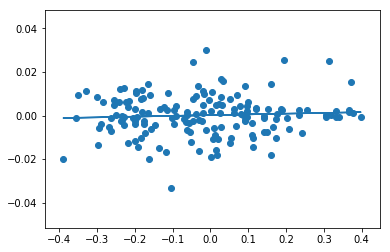

In [199]:
err = y - model.predict(X)
z = (rb10-rb1).values.reshape(-1,1)

b = np.bitwise_and(err > -0.4,err < 0.4)

err1 = err[b].reshape(-1,1)
z1 = z[b].reshape(-1,1)

err1 = err1[1:]
z1 = z1[1:]

model2 = LinearRegression()
model2.fit(err1,z1)

plt.scatter(err1,z1) # 看起来从凸度里面剥离期限利差会更好些
plt.plot(err1,model2.predict(err1))
model2.coef_,model2.intercept_,model2.score(err1,z1)

(array([[0.00735907]]), array([-0.00149668]), 0.008833744210789196)

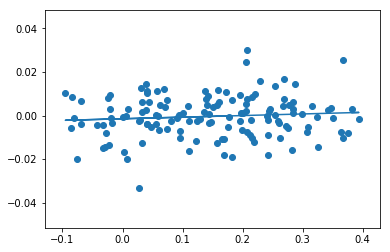

In [204]:
X3 = curv_mth.values.reshape(-1,1)

b = np.bitwise_and(X3 > -0.1,X3 < 0.4)
X3 = X3[b].reshape(-1,1)
z3 = z[b].reshape(-1,1)

X3 = X3[1:]
z3 = z3[1:]

model3 = LinearRegression()
model3.fit(X3,z3)

plt.scatter(X3,z3)
plt.plot(X3,model3.predict(X3))
model3.coef_,model3.intercept_,model3.score(X3,z3)

(array([[0.00394526]]), array([-0.00195522]), 0.022708232063162304)

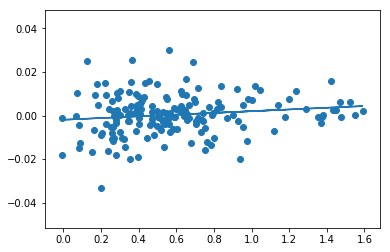

In [203]:
X = spd_mth.values.reshape(-1,1)
model4 = LinearRegression()
model4.fit(X[1:],z[1:])

plt.scatter(X[1:],z[1:])
plt.plot(X[1:],model4.predict(X[1:]))
model4.coef_,model4.intercept_,model4.score(X[1:,],z[1:])

# 曲线用于在Momentum上择时

In [154]:
X = curv_mth.values.reshape(-1,1)
#X = X.reshape(-1,2).  

y = alpha.values
y = y.reshape(-1,1)

model = LinearRegression()
model.fit(X[1:],y[1:])

y2 = model.predict(X[1:])
model.coef_, model.intercept_

(array([[-0.00156548]]), array([0.00115653]))

In [171]:
def ret3m(x):
    x3m = (x.rolling(3).sum())[2::3]
    return x3m

In [172]:
test = alpha.values[1:172].reshape(3,-1)
alpha3m = test.sum(axis=0)
alpha3m = alpha3m.T.reshape(-1,1)
alpha3m[0:5]

array([[-0.00755179],
       [ 0.00274654],
       [ 0.00565896],
       [ 0.00411514],
       [-0.00058063]])

In [298]:
alpha3m = ret3m(alpha)
rb10_3m = ret3m(rb10)
rb1_3m = ret3m(rb1)

curv3m = curv_mth.shift(-2)
curv3m = curv3m[2::3]

spd3m = spd_mth.shift(-2)
spd3m = spd3m[2::3]

curv3m.head()
curv3m.shape

(57,)

(array([[3.8012831e-05]]), array([0.00248689]), 1.5842627377748997e-06)

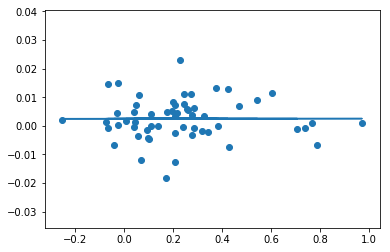

In [299]:
X = curv3m.values.reshape(-1,1)
y = alpha3m.values.reshape(-1,1)

model3m = LinearRegression()
model3m.fit(X,y)
plt.scatter(X,y)
plt.plot(X,model3m.predict(X))

model3m.coef_ , model3m.intercept_,model3m.score(X,y)

(array([[0.01687606]]), array([-0.00273632]), 0.05039214261454916)

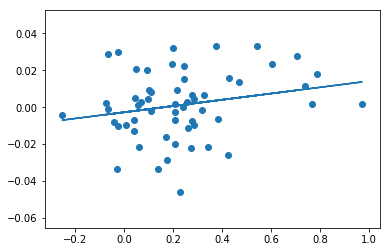

In [300]:
X = curv3m.values.reshape(-1,1)
y = (rb10_3m-rb1_3m).values.reshape(-1,1)

model3m = LinearRegression()
model3m.fit(X,y)
plt.scatter(X,y)
plt.plot(X,model3m.predict(X))

model3m.coef_ , model3m.intercept_,model3m.score(X,y)


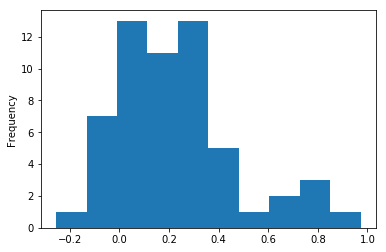

In [301]:
curv3m.plot(kind='hist')

In [305]:
curv3m.median()

0.20757142857142866

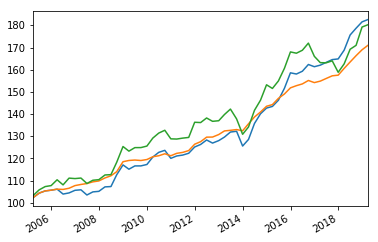

In [306]:
signal = curv3m-0.207
nav,ls = momentum(signal,rb10_3m,rb1_3m)
nav.plot()

nav1 = (rb1_3m+1).cumprod()*100
nav10 = (rb10_3m+1).cumprod()*100

nav1.plot()
nav10.plot()

0.5051777777777777

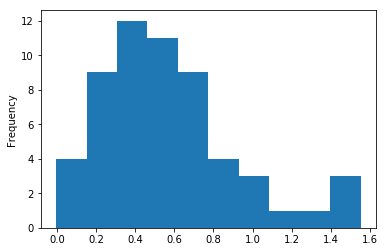

In [307]:
spd3m.plot(kind='hist')
spd3m.median()

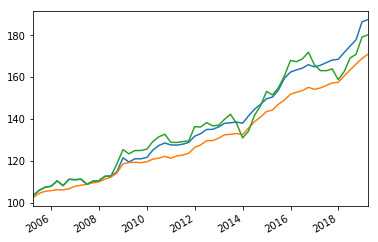

In [308]:
signal = spd3m-0.505
nav,ls = momentum(signal,rb10_3m,rb1_3m)
nav.plot()

nav1 = (rb1_3m+1).cumprod()*100
nav10 = (rb10_3m+1).cumprod()*100

nav1.plot()
nav10.plot()

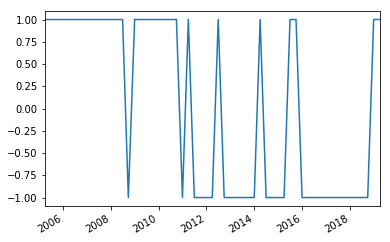

In [312]:
ls.plot()

In [314]:
np.max(nav/nav.shift(1)-1)

0.0599026133754359

# 前半年股票指数收益是不是负相关？南华工业品指数？